In [1]:
from Models.MainModel import InitModel
from Config import Config
from Utils.Visualization import ShowOcclusionSensitivity

import random
import torch
from torch import nn
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [2]:
random.seed(0)

In [3]:
config = Config()
config.apply()

In [4]:
checkpoint_path = 'Checkpoints/FF++_c23/checkpoint_25.pth'
transform = config.test.transform['standard']

In [5]:
def model_prep():
    global model
    model = InitModel(config)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model = nn.DataParallel(model)

    model.eval()
    model.cuda()
    

def input_prep():
    global input_tensor
    # Load video frames from data_path to `frames` using cv2
    vidcap = cv2.VideoCapture(data_path)
    frames = []
    for i in range(14):
        success, frame = vidcap.read()
        frames.append(frame)
    vidcap.release()
    input_tensor = torch.FloatTensor(14, 3, 224, 224)
    for i in range(14):
        input_tensor[i] = transform(Image.fromarray(frames[i]))
    input_tensor = torch.unsqueeze(input_tensor, 0).cuda()

In [6]:
data_paths = [
    "/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/real_test/real_467_8.mp4",
    "/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/real_test/real_485_33.mp4",
    "/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/real_test/real_924_21.mp4",
    "/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/Face2Face_625_650_4.mp4",
    "/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/FaceSwap_973_970_5.mp4",
    "/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/Deepfakes_379_158_3.mp4",
    "/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/Face2Face_868_949_4.mp4",
    "/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/FaceSwap_319_352_0.mp4"
]

Initializing base model
/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/real_test/real_467_8.mp4
tensor([4.6020e-04, 9.9954e-01], device='cuda:0', grad_fn=<MeanBackward1>)
 > Prediction: [4.6020129e-04 9.9953985e-01]


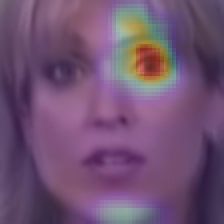

1 0 0 0
/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/real_test/real_485_33.mp4
tensor([2.9127e-04, 9.9971e-01], device='cuda:0', grad_fn=<MeanBackward1>)
 > Prediction: [2.9127172e-04 9.9970871e-01]


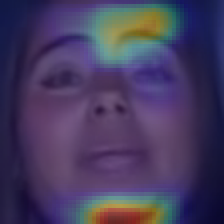

2 0 0 0
/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/real_test/real_924_21.mp4
tensor([3.2359e-06, 1.0000e+00], device='cuda:0', grad_fn=<MeanBackward1>)
 > Prediction: [3.2358976e-06 9.9999678e-01]


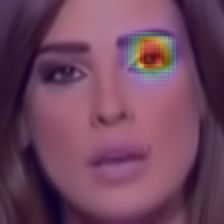

3 0 0 0
/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/Face2Face_625_650_4.mp4
tensor([9.9999e-01, 5.8278e-06], device='cuda:0', grad_fn=<MeanBackward1>)
 > Prediction: [9.9999416e-01 5.8277619e-06]


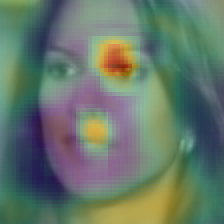

3 0 1 0
/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/FaceSwap_973_970_5.mp4
tensor([1.0000e+00, 3.7377e-06], device='cuda:0', grad_fn=<MeanBackward1>)
 > Prediction: [9.999963e-01 3.737673e-06]


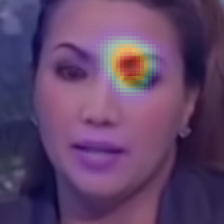

3 0 2 0
/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/Deepfakes_379_158_3.mp4
tensor([1.0000e+00, 2.1007e-06], device='cuda:0', grad_fn=<MeanBackward1>)
 > Prediction: [9.9999785e-01 2.1006867e-06]


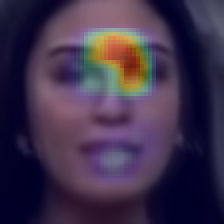

3 0 3 0
/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/Face2Face_868_949_4.mp4
tensor([9.9998e-01, 1.9412e-05], device='cuda:0', grad_fn=<MeanBackward1>)
 > Prediction: [9.9998057e-01 1.9411757e-05]


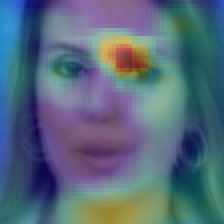

3 0 4 0
/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/FaceSwap_319_352_0.mp4
tensor([1.0000e+00, 2.0255e-07], device='cuda:0', grad_fn=<MeanBackward1>)
 > Prediction: [9.9999976e-01 2.0255149e-07]


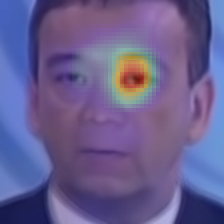

3 0 5 0


In [7]:
eval_type = {
    'TP': [],
    'TN': [],
    'FP': [],
    'FN': [],
}
collect_types = ['TN', 'TP']
amt_per_type = 10

model = None
model_prep()

for data_path in data_paths:
    
    print(data_path)
    
    ground_truth_label = 1
    if 'fake' in data_path or 'synthesis' in data_path:
        ground_truth_label = 0
    
    temp_set = []
    eval_result = None
    
    input_tensor = None
    input_prep()

    # Get Result
    prediction = model(input_tensor)
    input_tensor = input_tensor.detach().cpu()
    del input_tensor
    print(torch.mean(prediction, axis=0))
    predicted_label = int(torch.mean(prediction, axis=0).argmax())
    
    if torch.max(torch.mean(prediction, axis=0)) < 0.7:
        continue

    if predicted_label == 1 and ground_truth_label == 1 and len(eval_type['TP']) < amt_per_type:
        eval_result = 'TP'
    elif predicted_label == 0 and ground_truth_label == 0 and len(eval_type['TN']) < amt_per_type:
        eval_result = 'TN'
    elif predicted_label == 1 and ground_truth_label == 0 and len(eval_type['FP']) < amt_per_type:
        eval_result = 'FP'
    elif predicted_label == 0 and ground_truth_label == 1 and len(eval_type['FN']) < amt_per_type:
        eval_result = 'FN'
    if eval_result is None:
        break
    
    if eval_result not in collect_types:
        print('Skip')
        continue

    final_img, heatmap = ShowOcclusionSensitivity(model, data_path, transform, cube_size=32, step=4, batch_size=1, oneImg=False)
    temp_set.append([final_img, heatmap])
    
    eval_type[eval_result].append([data_path, temp_set])
    
    print(len(eval_type['TP']), len(eval_type['FP']), len(eval_type['TN']), len(eval_type['FN']))
    
    if len(eval_type['TP']) + len(eval_type['FP']) + len(eval_type['TN']) + len(eval_type['FN']) == amt_per_type*len(collect_types):
        print('Finished')
        break

In [8]:
torch.save(eval_type, 'Results/GazeForensics_OccSensitivity.pkl')

In [9]:
eval_type = torch.load('Results/GazeForensics_OccSensitivity.pkl')

/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/real_test/real_467_8.mp4


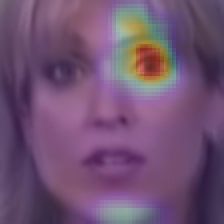

/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/real_test/real_485_33.mp4


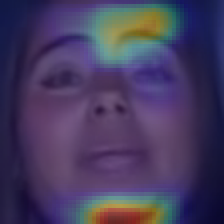

/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/real_test/real_924_21.mp4


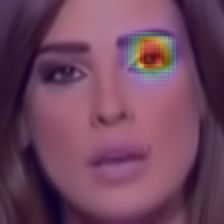

/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/Face2Face_625_650_4.mp4


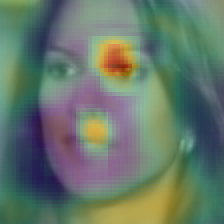

/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/FaceSwap_973_970_5.mp4


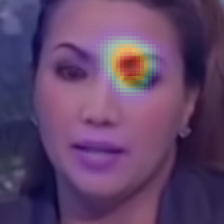

/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/Deepfakes_379_158_3.mp4


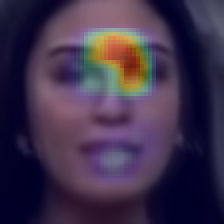

/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/Face2Face_868_949_4.mp4


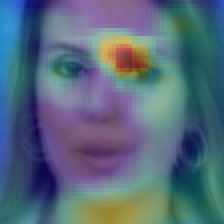

/home/kyr/GazeForensicsData/clipped_videos/FF++_c23_clip/fake_test/FaceSwap_319_352_0.mp4


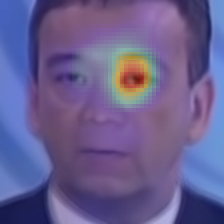

In [10]:
all_data = []
for key in eval_type.keys():
    all_data.extend(eval_type[key])
for data in all_data:
    print(data[0])
    data[1][0][0].show()

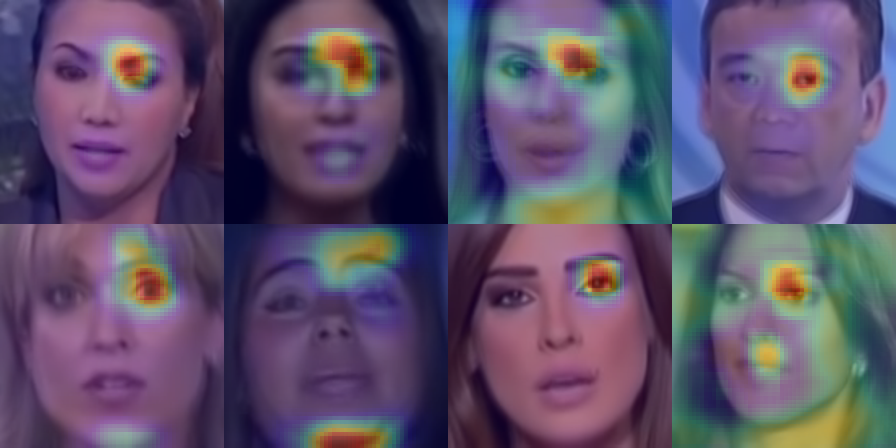

In [11]:
concatenated_image = Image.new('RGB', (224*4, 224*2))
for i in range(8):
    concatenated_image.paste(all_data[i][1][0][0], (224 * (i % 4), 224 * int(i<4)))
concatenated_image.save('Results/GazeForensics_Occlusion_Sensitivity.png')
concatenated_image.show()

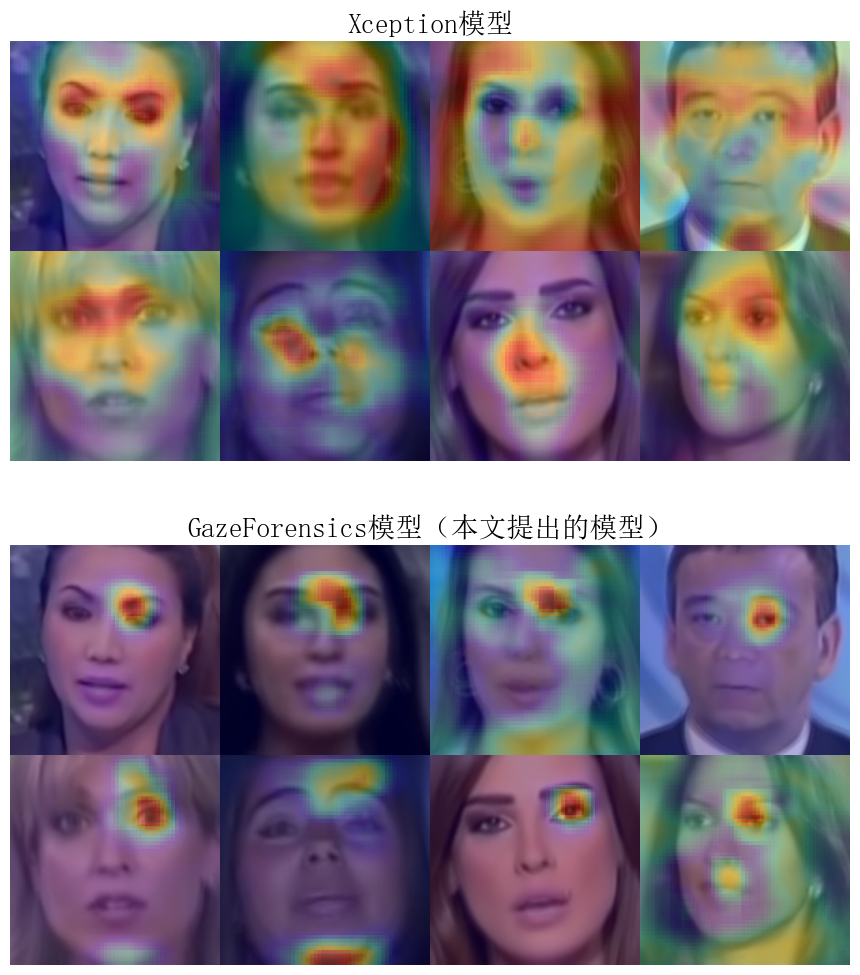

In [3]:
# plt.rcParams['font.family'] = 'SimSun'

img1 = Image.open('Results/GazeForensics_Occlusion_Sensitivity.png')
img2 = Image.open('Results/Xception_Occlusion_Sensitivity.png')

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
fontsize = 20

axes[0].imshow(img2)
axes[0].set_title('Xception', fontsize=fontsize)
# axes[0].set_title('Xception模型', fontsize=fontsize)
axes[0].axis('off')

axes[1].imshow(img1)
axes[1].set_title('GazeForensics(ours)', fontsize=fontsize)
# axes[1].set_title('GazeForensics模型（本文提出的模型）', fontsize=fontsize)
axes[1].axis('off')

plt.savefig('Results/OcclusionSensitivity.pdf', bbox_inches='tight')
plt.show()